In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from diffusers import StableDiffusionInpaintPipeline, AutoPipelineForInpainting

from PIL import Image
import numpy as np

import torch
from torchvision import transforms

from tqdm.auto import tqdm

# stable diffusion inpainting

In [ ]:
model_path = './ned-v1-22-inpainting-A62B4AC3A2.safetensors'
# tokenizer_path = './input/model/clip/txt_emb_tokenizer'
# text_model_path = './input/model/clip/txt_emb_model'
tokenizer_path = '/input/models/tokenizer/'
text_model_path = '/input/models/text_encoder/'
config_path = './configs/v1-inpainting-inference.yaml'

In [ ]:
# pipe = StableDiffusionInpaintPipeline.from_pretrained(
#     "runwayml/stable-diffusion-inpainting",
#     torch_dtype=torch.float16, local_files_only=True
# ).to("cuda")

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
text_encoder = CLIPTextModel.from_pretrained(text_model_path, local_files_only=True).cuda().eval()

In [ ]:
# pip install omegaconf -i https://pypi.tuna.tsinghua.edu.cn/simple
# pip install accelerate -i https://pypi.tuna.tsinghua.edu.cn/simple

# https://github.com/vladmandic/automatic/blob/e750112612f079dc18b13edb365c79ad1c7eb511/modules/sd_models.py#L785
pipe =  StableDiffusionInpaintPipeline.from_single_file(
    pretrained_model_link_or_path=model_path,
    config_files={'v1': config_path},
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    local_files_only=True, use_safetensors=True, load_safety_checker=False
).to("cuda")

pipe.set_progress_bar_config(disable=True)

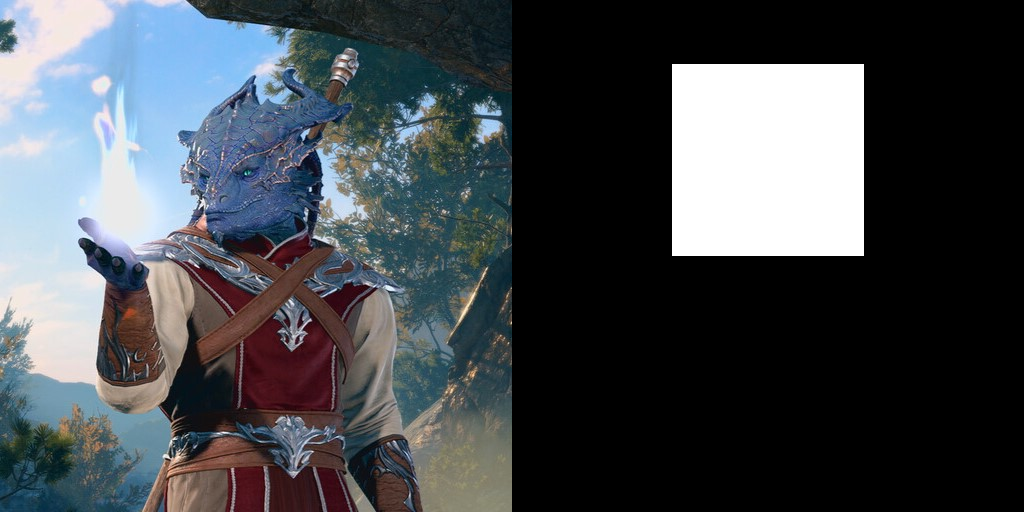

In [3]:
prompt = 'a handsome man with ray-ban sunglasses'

init_image = Image.open('./demo.jpg').convert("RGB").resize((512, 512))

mask = np.zeros((512, 512))
mask[64:256, 160:352] = 1
# mask[192:320, 192:320] = 1
mask = Image.fromarray(mask > 0).convert("RGB").resize((512, 512))

Image.fromarray(np.concatenate([np.array(init_image), np.array(mask)], axis=1))

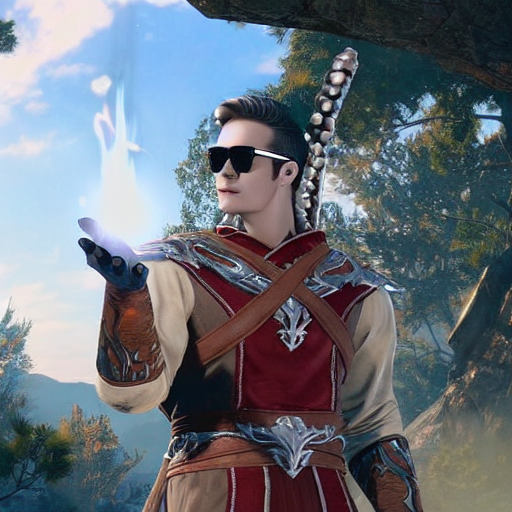

In [6]:
with torch.no_grad():
    image = pipe(
        prompt=prompt, image=init_image, mask_image=mask, num_inference_steps=20, strength=0.75, guidance_scale=7.5
    )
image.images[0]

# Kandinsky 2.2 inpainting

In [2]:
pipe = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", 
    torch_dtype=torch.float16
).to('cuda')

pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
prompt = '2d, video game, side scrolling, pixel graphic, level design, in an alien planet, environmental'

In [ ]:
# init_image = Image.fromarray((np.random.rand(512, 512, 3) * 255.).astype('uint8')).convert("RGB").resize((512, 512))
init_image = Image.fromarray(np.ones((512, 512)) > 0).convert("RGB").resize((512, 512))

# with torch.no_grad():
    
#     mask = Image.fromarray(np.ones((512, 512)) > 0).convert("RGB").resize((512, 512))
    
#     init_image = pipe(
#         prompt=prompt, image=init_image, mask_image=mask, num_inference_steps=20, strength=1., guidance_scale=7.5
#     ).images[0]

image = Image.fromarray(np.array(init_image))
images = [image]

masked = np.zeros((512, 512))
inpaint_size = 128

for i in tqdm(range(100)):

    mask = np.zeros((512, 512))

    x = np.random.randint(0, 512 - inpaint_size)
    y = np.random.randint(0, 512 - inpaint_size)

    mask[x:x+inpaint_size, y:y+inpaint_size] = 1
    masked += mask
    mask = Image.fromarray(mask > 0).convert("RGB").resize((512, 512))
    
    with torch.no_grad():
        inpainted_image = pipe(
            prompt=prompt, image=image, mask_image=mask, num_inference_steps=20, strength=0.9, guidance_scale=7.5
        ).images[0]

    image = np.array(image)
    inpainted_image = np.array(inpainted_image)
    image[x:x+inpaint_size, y:y+inpaint_size] = inpainted_image[x:x+inpaint_size, y:y+inpaint_size]

    image = Image.fromarray(image)
    images.append(image)

Image.fromarray(np.concatenate([
    np.array(init_image), 
    np.array(image), 
    np.array(Image.fromarray(masked > 0).convert("RGB").resize((512, 512)))
], axis=1))

In [6]:
images[0].save(
    './tmp/Kandinsky_inpainting_from_empty_strength_0.9_environmental.gif',
    save_all=True, append_images=images[1:], 
    optimize=False, duration=200, loop=1
)